## Setup

First, we need to setup an access to *Google Drive*. This is to persist data or artifacts in a local drive even when we are not connected to *Google Colab*.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Then, install `ipywidgets` and `fastai` as necessary dependencies and import them.

In [2]:
!python -m pip install -Uqq ipywidgets fastai

In [3]:
from fastai.vision.all import *

## Introduction

### Why Deep Learning?

This is a starting point to your deep learning journey. Before we dive into what you need to know about it and how, it is important to talk about **Why?**.

* **It is for everyone:** One might say deep learning is like a blackbox. However, the truth is in practice, what you want to do is just to solve problem of your own interests and there are a lot of state-of-the-art models to help you do that.
* **Huge amount of data:** A lot of open-source and pre-trained model out there! So, there is no need for you to start collecting data from scratch just a few samples of it.
* **High computational resources:** You do not need to be *Google* or *Microsoft* to train such large models. Nowadays, everyone can access this kind of computational resouce for free.
* **Good for thousands of use cases in different areas:** There are remarkable accomplishment throughout the recent years that deep learning helps researchers and practitioners solve. Here is some of them:
    * Natural language processing (NLP): answering questions; speech recognition; summarizing documents; classifying documents; translation;information retrieval (searching). Here is my recommendation on [a comprehensive guide to NLP](https://www.deeplearning.ai/resources/natural-language-processing/).
    * Computer vision: image recognition; image captioning; image segmentation; image generation.
    * Recommendation systems: product recommendations; web searching.
    * Games: chess; go; real-time strategy games like StarCrafts.
    * Others: algoritmic trading; text-to-speech.

### Neural Networks: A Brief History

This is a simplified verison of ANNs history that you will help you contextualize on what we have been through and learn to not repeat some of it!

```mermaid
flowchart LR;
    A[Artificial Neurons] -- Unrecognized social position --> B[Perceptrons] -- Failure to learn simple XOR --> C[PDP] -- Approximation with one extra layer --> D[Modern ANNs];
```

Basically, what researchers have tried to do since 1943 is to develop a mathematical model of an artificial neuron inspired by the human brain. Although there are several years of misunderstanding of the theoretical issues, we still have multi-volume Parallel Distributed Processing (PDP) which acts as a backbone of modern ANNs. Here is the required components for this framework:

1. A set of processing units
2. A state of activation
3. An output function for each unit
4. A pattern of connectivity among units
5. A propagation rule for propagating patterns of activities through the network of connectivities
6. An activation rule for combining the inputs impinging on a unit with the current state of that unit to produce an output for the unit
7. A learning rule whereby patterns of connectivity are modified by experience
8. An environment within which the system must operate

Again, thanks to the use of more layers, together with the improvement in hardware capability, the increase amount of data and algorithmic tweaks that allow neural networks to be trained faster and more easily, We now are able to complete complex tasks like an image recognizer by a only computer.

### Cats and Dogs

Let's implement *PDP* framework in practice by using a *pre-trained model* to complete a task; an image recognizer perhaps. Here is what about to happen:

1. A dataset called the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) that contains 7,349 images of cats and dogs from 37 different breeds will be downloaded from the fast.ai datasets collection to the GPU server you are using, and will then be extracted.
2. A *pretrained model* that has already been trained on 1.3 million images, using a competition-winning model will be downloaded from the internet.
3. The pretrained model will be *fine-tuned* using the latest advances in transfer learning, to create a model that is specially customized for recognizing dogs and cats.

In [4]:
path = untar_data(URLs.PETS)/'images'

is_cat = lambda x: x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 90.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.163383,0.030820,0.012179,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.055516,0.037565,0.012855,01:00


:::{.callout-important}
Depending on your network speed, it might take a few minutes to download the pretrained model and dataset. Running `fine_tune` might take a minute or so. Often models in this book take a few minutes to train, as will your own models, so it's a good idea to come up with good techniques to make the most of this time. For instance, keep reading the next section while training your model, or open up another notebook and use it for some coding experiments.
:::

After we have trained the model, we need to check if it can do something useful right? There are several ways we can do. The first way is to create an uploader for an interaction. This way is the simplest and suitable for users similiarized with *GUI*.

In [10]:
from ipywidgets import FileUpload

# This should prompt a uploader UI for file attachment
uploader = FileUpload()
uploader

FileUpload(value={}, description='Upload')

Or you can just past in a download link to `download_image` function provided by `fastai` library.

In [20]:
dest = Path("gdrive/My Drive/practical-deep-learning/bin/")
download_images(dest, urls=["https://i.icanvas.com/COC490?d=3&sh=v&s=xl&p=1&bg=g&t=1648830566"])

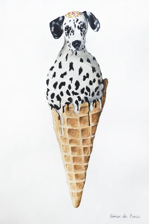

In [23]:
img = PILImage.create("/content/gdrive/MyDrive/practical-deep-learning/bin/75083824-ac57-46d2-acdb-2e0678aba62f.jpg")
img.to_thumb(224)

In [27]:
is_cat, _, probs = learn.predict(img)

print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1]:.4f}")

Is this a cat?: False.
Probability it's a cat: 0.0357


As you can see, the model can correctly classify even an image has some part that is not a dog! This is the power of a pre-trained model.

But what does it actually doing? we will have a look more closer into the code.

#### How Our Image Recognizer works

Let's look through the code first.

`untar_data` function has downloaded a standardard dataset from the [fast.ai datasets collection](https://course.fast.ai/datasets) (if not previously downloaded) to your server, extracts it (if not previously extracted), and returns a `Path` object with the extracted location:

```python
path = untar_data(URLs.PETS)/'images'
```

Next, we define a function, `is_cat`, which labels cats based on a filename rule provided by the dataset creators:

```python
is_cat = lambda x: x[0].isupper()
```

Then, we need to tell `fastai` what kind of dataset we have and how it is structured:

```python
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
```

There are various different classes for different kinds of deep learning datasets and problems—here we're using `ImageDataLoaders`. The first part of the class name will generally be the type of data you have, such as image, or text.

The other important piece of information that we have to tell `fastai` is how to get the labels from the dataset. Computer vision datasets are normally structured in such a way that the label for an image is part of the filename, or path—most commonly the parent folder name. fastai comes with a number of standardized labeling methods, and ways to write your own. Here we're telling fastai to use the `is_cat` function we just defined.

Finally, we define the `Transform`s that we need. A `Transform` contains code that is applied automatically during training; fastai includes many predefined `Transform`s, and adding new ones is as simple as creating a Python function. There are two kinds: `item_tfms` are applied to each item (in this case, each item is resized to a 224-pixel square), while `batch_tfms` are applied to a *batch* of items at a time using the GPU, so they're particularly fast!

Why 224 pixels? This is the standard size for historical reasons (old pretrained models require this size exactly), but you can pass pretty much anything. If you increase the size, you'll often get a model with better results (since it will be able to focus on more details), but at the price of speed and memory consumption; the opposite is true if you decrease the size.

The Pet dataset contains 7,390 pictures of dogs and cats, consisting of 37 different breeds. Each image is labeled using its filename: for instance the file *great\_pyrenees\_173.jpg* is the 173rd example of an image of a Great Pyrenees breed dog in the dataset. The filenames start with an uppercase letter if the image is a cat, and a lowercase letter otherwise. We have to tell `fastai` how to get labels from the filenames, which we do by calling `from_name_func` (which means that labels can be extracted using a function applied to the filename), and passing `is_cat`, which returns `x[0].isupper()`, which evaluates to `True` if the first letter is uppercase (i.e., it's a cat).

The most important parameter to mention here is `valid_pct=0.2`. This tells `fastai` to hold out 20% of the data and *not use it for training the model at all*. This 20% of the data is called the *validation set*; the remaining 80% is called the *training set*. The validation set is used to measure the accuracy of the model. By default, the 20% that is held out is selected randomly. The parameter `seed=42` sets the *random seed* to the same value every time we run this code, which means we get the same validation set every time we run it—this way, if we change our model and retrain it, we know that any differences are due to the changes to the model, not due to having a different random validation set.

Next, it tells ``fastai` to create a *convolutional neural network* (CNN) and specifies what *architecture* to use (i.e. what kind of model to create), what data we want to train it on, and what *metric* to use:

```python
learn = vision_learner(dls, resnet34, metrics=error_rate)
```

Why a CNN? It's the current state-of-the-art approach to creating computer vision models. Their structure is inspired by how the human vision system works.

There are many different architectures in `fastai`, which we will introduce in the later lecture (as well as discussing how to create your own). Most of the time, however, picking an architecture isn't a very important part of the deep learning process. It's something that academics love to talk about, but in practice it is unlikely to be something you need to spend much time on. There are some standard architectures that work most of the time, and in this case we're using one called _ResNet_ that we'll be talking a lot about during the book; it is both fast and accurate for many datasets and problems. The `34` in `resnet34` refers to the number of layers in this variant of the architecture (other options are `18`, `50`, `101`, and `152`). Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.

What is a metric? A *metric* is a function that measures the quality of the model's predictions using the validation set, and will be printed at the end of each *epoch*. In this case, we're using `error_rate`, which is a function provided by `fastai` that does just what it says: tells you what percentage of images in the validation set are being classified incorrectly. Another common metric for classification is `accuracy` (which is just `1.0 - error_rate`). There are many more to cover in the later lecture.

The concept of a metric may remind you of *loss*, but there is an important distinction. The entire purpose of loss is to define a "measure of performance" that the training system can use to update weights automatically. In other words, a good choice for loss is a choice that is easy for stochastic gradient descent to use. But a metric is defined for human consumption, so a good metric is one that is easy for you to understand, and that hews as closely as possible to what you want the model to do. At times, you might decide that the loss function is a suitable metric, but that is not necessarily the case.

`vision_learner` also has a parameter `pretrained`, which defaults to `True` (so it's used in this case, even though we haven't specified it), which sets the weights in your model to values that have already been trained by experts to recognize a thousand different categories across 1.3 million photos (using the famous [*ImageNet* dataset](http://www.image-net.org/)). A model that has weights that have already been trained on some other dataset is called a *pretrained model*. You should nearly always use a pretrained model, because it means that your model, before you've even shown it any of your data, is already very capable. And, as you'll see, in a deep learning model many of these capabilities are things you'll need, almost regardless of the details of your project. For instance, parts of pretrained models will handle edge, gradient, and color detection, which are needed for many tasks.

When using a pretrained model, `vision_learner` will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the *head*.

Using pretrained models is the *most* important method we have to allow us to train more accurate models, more quickly, with less data, and less time and money. You might think that would mean that using pretrained models would be the most studied area in academic deep learning... but you'd be very, very wrong! The importance of pretrained models is generally not recognized or discussed in most courses, books, or software library features, and is rarely considered in academic papers.

Using a pretrained model for a task different to what it was originally trained for is known as *transfer learning*. Unfortunately, because transfer learning is so under-studied, few domains have pretrained models available. For instance, there are currently few pretrained models available in medicine, making transfer learning challenging to use in that domain. In addition, it is not yet well understood how to use transfer learning for tasks such as time series analysis.

:::{.callout-note}
Transfer learning: using a pretrained model for a task different to what it was originally trained for.
:::

Here comes our training part. Our code tells `fastai` how to *fit* the model:

```python
learn.fine_tune(1)
```

As we've discussed, the architecture only describes a *template* for a mathematical function; it doesn't actually do anything until we provide values for the millions of parameters it contains.

This is the key to deep learning—determining how to fit the parameters of a model to get it to solve your problem. In order to fit a model, we have to provide at least one piece of information: how many times to look at each image (known as number of *epochs*). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.

But why is the method called `fine_tune`, and not `fit`? `fastai` actually *does* have a method called `fit`, which does indeed fit a model (i.e. look at images in the training set multiple times, each time updating the parameters to make the predictions closer and closer to the target labels). But in this case, we've started with a pretrained model, and we don't want to throw away all those capabilities that it already has. There are some important tricks that we are going to learn throughout the course to adapt a pretrained model for a new dataset — a process called *fine-tuning*.

:::{.callout-note}
Fine-tuning: a transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a similar task and dataset.
:::

When you use the `fine_tune` method, `fastai` will use these tricks for you. There are a few parameters you can set (which we'll discuss later), but in the default form shown here, it does two steps:

1. Use one epoch to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.
1. Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).

The *head* of a model is the part that is newly added to be specific to the new dataset. An *epoch* is one complete pass through the dataset. After calling `fit`, the results after each epoch are printed, showing the epoch number, the training and validation set losses (the "measure of performance" used for training the model), and any *metrics* you've requested (error rate, in this case).

#### Whar Our Image Recognizer Learned

Before going to the next section, we have already know what our code has been doing. That's good!

But intuition behind it, it also important for you as there is the key you can use to adapt this code to any kind of problems.

In 2013 a PhD student, Matt Zeiler, and his supervisor, Rob Fergus, published the paper ["Visualizing and Understanding Convolutional Networks"](https://arxiv.org/pdf/1311.2901.pdf), which showed how to visualize the neural network weights learned in each layer of a model. They carefully analyzed the model that won the 2012 ImageNet competition, and used this analysis to greatly improve the model, such that they were able to go on to win the 2013 competition!

You can see pictures of each layer in their paper. So, I am going to summarize here:

> As the layer go deeper, the model learns more sophiticated features.

This statement provides an inspiration to what neural networks do in what so called the "blackbox". Also, it is a confirmation that neural networks themselves have the ability to learn feature on theirown. This gives us a lot of potential:

* We do not need *hand-crafted features* and preserve the nature of dataset.
* Flexibility on how to use the neural networks on every possible data format that you can imagine.

## What Is Machine Learning?

Now that we have learn deep learning through hands-on exercise, It is time to dig a lit bit deeper into it. We will start with *Machine Learning*.

This term is like a primitive to *Deep Learning*. What is means is that it is another paradiagm (as opposed to *Traditional Programming*) to get computers to complete a specific task. The key difference is here:

> ML provides an ability for a computer to learn without explitcitly being programmed

Here is [an introduction to machine learning](https://vas3k.com/blog/machine_learning/) that I find easily to get started. This blog includes the main concepts and its real-world examples.

Now, back to business, the basic of every traditional program should look like this:

```mermaid
flowchart LR;
    A([inputs]) --> B[program] --> C([results]);
```

However, for tasks like image recognition. It is almost impossible for you as a programmer who write an *instruction* to turn *inputs* into *results* as we are human that can do it unconsciouly. Therefore, the new paradiagm to the problem comes in. **Machine Learning** seem like a good way to solve the problem but in reality how can we implement it.

Remember *PDP* framework? we need various components for a computer to utilize in order to acheive our goal. The concepts like "weight assignment" and "performance evaluation" have emerged though it is crucial for a computer to do it automatically. So, we also need some **mechanism** to provide the ability to automate the process of improvement and make sure that the model can do whatever it is required to do. Here is the summary of what it should be look like:

```mermaid
flowchart LR;
    A([inputs]) --> C[model];
    B([weights]) --> C[model];
    C[model] --> D([results]);
    D([results]) --> E([performance]);
    E([performance]) -- update --> B([weights]);
```

Such **mechanism** keep the model going toward perfection as it iteratively update weights. Also note that once the model is finished training, the weight themselves act as a part of the model.

So, the simplfied version of it would be something which quite similar to what traditional programming is:

```mermaid
flowchart LR;
    A([inputs]) --> B[model] --> C([results]);
```

### What Is a Neural Network?

*Neural Network* is just another algorithm for *Machine Learning* like *Random Forest* or *Gradient Boosting* and that's it! That is a neural network in a nutshell.

Although neural network seems very complex, the beginning of it is quite intuitive as it is inspired by the human brain cells using a mathematical function and it turns out to be a very powerful and flexible function which depends only on its weights. A mathematical proof called the *universal approximation theorem* shows that this function can solve any problem to any level of accuracy, in theory.

However, in practice there are many caveats to it like the quality of dataset, the hardware computation used to run those neural networks or the trade-off between time and cost of big networks.

Nowadays, the term *Deep Learning* has replaced *Neural Network* as nobody build a couple layers of the network anymore. People tends to go **deeper** like the name suggested. Thanks to its graph-like nature, it is still quickly understandable through visual representation and great resources online help practitioner a lot in doing so.

Alright but here comes the question — if we have such a good template or so called "architecture" let say a very deep one, then how we are going to train it? how we know that it is optimized with the correct set of weights?

The answer is we need a **mechanism** like in traditional machine learning. But in deep learning, this mechanism is called *stochastic gradient descent* (SGD). Unlike in the traditional machine learning, SGD is also very flexible and can be used to update weights in every architectures that we can imagine. Here is a process looks like:

```mermaid
flowchart LR;
    A([inputs]) --> C[architecture];
    B([parameters]) --> C[architecture];
    C[architecture] --> D([predictions]);
    D([predictions]) --> E([loss]);
    E([loss]) -- update --> B([parameters]);
```

As you can see, although we use different terminologies, they are basically the same. The only thing I need to point out is in deep learning, we use SGD to optimize our model parameters.

### Tips and Tricks

In machine learning, of course it has a limitation but this should not stop you and I will tell you the important tips and tricks on how to handle it and provide you with an inspiration of its potential so that you will have a solid foundation to be able to complete any task that you are interested in.

Here is a [Machine Learning tips and tricks](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks) and [Deep Learning Tips and Tricks](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks) that I find useful.

#### Solve a problem with data preprocessing

This in my opinion the most powerful tips and tricks that I want to hightlight. As you can see from the example, an image recognizer is very handy when it comes to image classification task.

But can it tackle something that is not related to an image? — Actually it can and it can do it pretty well too.

For instance, a sound can be converted to a spectrogram, which is a chart that shows the amount of each frequency at each time in an audio file. Fast.ai student Ethan Sutin used this approach to easily beat the published accuracy of a state-of-the-art [environmental sound detection model](https://medium.com/@etown/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52) using a dataset of 8,732 urban sounds. fastai's `show_batch` clearly shows how each different sound has a quite distinctive spectrogram

<img alt="show_batch with spectrograms of sounds" width="400" caption="show_batch with spectrograms of sounds" id="img_spect" src="https://github.com/fastai/fastbook/blob/master/images/att_00012.png?raw=1">

A time series can easily be converted into an image by simply plotting the time series on a graph. However, it is often a good idea to try to represent your data in a way that makes it as easy as possible to pull out the most important components. In a time series, things like seasonality and anomalies are most likely to be of interest. There are various transformations available for time series data. For instance, fast.ai student Ignacio Oguiza created images from a time series dataset for olive oil classification, using a technique called Gramian Angular Difference Field (GADF). He then fed those images to an image classification model just like the one you see in this chapter. His results, despite having only 30 training set images, were well over 90% accurate, and close to the state of the art.

<img alt="Converting a time series into an image" width="700" caption="Converting a time series into an image" id="ts_image" src="https://github.com/fastai/fastbook/blob/master/images/att_00013.png?raw=1">

It change our way of thinking as well. It shows that:

> Deep learning is very powerful tool for you to use, you just need to find a way to properly represent your data to it

Note that some techniques require only intuition of the data like an environmental sound detection model. However, some demands more in-depth methods to handle the data such as a olive oil classification. Someone might refer to it as "hacky workarounds".

#### Biases in Dataset

There are several ways that you can do that makes your project getting a bias result. Most parts come from the way you handle your data.

##### Data collection
The first process that you can give a bias to your data is when you are collecting them. Generally speaking, we've seen that most organizations that say they don't have enough data, actually mean they don't have enough *labeled* data. So, they need to gather it.

I want to pause here a bit. As datasets is very critical to the model like a food. So, throughout the course, think about where the dataset might have come from, and how they might have been curated. Then think about what kinds of interesting datasets you could create for your own projects. Trust me, this will also be a valuable skill for you as a practitioner.

Back to business, Gathering data might create what so called *feedback loops*, as describe here:

- A *predictive policing* model is created based on where arrests have been made in the past. In practice, this is not actually predicting crime, but rather predicting arrests, and is therefore partially simply reflecting biases in existing policing processes.
- Law enforcement officers then might use that model to decide where to focus their police activity, resulting in increased arrests in those areas.
- Data on these additional arrests would then be fed back in to retrain future versions of the model.

This is a *positive feedback loop*, where the more the model is used, the more biased the data becomes, making the model even more biased, and so forth.

Feedback loops can also create problems in commercial settings. For instance, a video recommendation system might be biased toward recommending content consumed by the biggest watchers of video (e.g., conspiracy theorists and extremists tend to watch more online video content than the average), resulting in those users increasing their video consumption, resulting in more of those kinds of videos being recommended. We'll consider this topic more in detail in the later chapter about ethics.

##### Validation Set and Test Set

In practice, what you want to do really is making your model working for others. Therefore, validation and evaluation your model are the important steps as well as training which if you have done it properly, we are one step closer to your goal!

To do this, our first step was to split our dataset into two sets: the *training set* (which our model sees in training) and the *validation set*, also known as the *development set* (which is used only for evaluation). This lets us test that the model learns lessons from the training data that generalize to new data, the validation data.

One way to understand this situation is that, in a sense, we don't want our model to get good results by "cheating." If it makes an accurate prediction for a data item, that should be because it has learned characteristics of that kind of item, and not because the model has been shaped by *actually having seen that particular item*.

Splitting off our validation data means our model never sees it in training and so is completely untainted by it, and is not cheating in any way. Right?

In fact, not necessarily. The situation is more subtle. This is because in realistic scenarios we rarely build a model just by training its weight parameters once. Instead, we are likely to explore many versions of a model through various modeling choices regarding network architecture, learning rates, data augmentation strategies, and other factors we will discuss in upcoming chapters. Many of these choices can be described as choices of *hyperparameters*. The word reflects that they are parameters about parameters, since they are the higher-level choices that govern the meaning of the weight parameters.

The problem is that even though the ordinary training process is only looking at predictions on the training data when it learns values for the weight parameters, the same is not true of us. We, as modelers, are evaluating the model by looking at predictions on the validation data when we decide to explore new hyperparameter values! So subsequent versions of the model are, indirectly, shaped by us having seen the validation data. Just as the automatic training process is in danger of overfitting the training data, we are in danger of overfitting the validation data through human trial and error and exploration.

The solution to this conundrum is to introduce another level of even more highly reserved data, the *test set*. Just as we hold back the validation data from the training process, we must hold back the test set data even from ourselves. It cannot be used to improve the model; it can only be used to evaluate the model at the very end of our efforts. In effect, we define a hierarchy of cuts of our data, based on how fully we want to hide it from training and modeling processes: training data is fully exposed, the validation data is less exposed, and test data is totally hidden. This hierarchy parallels the different kinds of modeling and evaluation processes themselves—the automatic training process with back propagation, the more manual process of trying different hyper-parameters between training sessions, and the assessment of our final result.

The test and validation sets should have enough data to ensure that you get a good estimate of your accuracy. If you're creating a cat detector, for instance, you generally want at least 30 cats in your validation set. That means that if you have a dataset with thousands of items, using the default 20% validation set size may be more than you need. On the other hand, if you have lots of data, using some of it for validation probably doesn't have any downsides.

Having two levels of "reserved data"—a validation set and a test set, with one level representing data that you are virtually hiding from yourself—may seem a bit extreme. But the reason it is often necessary is because models tend to gravitate toward the simplest way to do good predictions (memorization), and we as fallible humans tend to gravitate toward fooling ourselves about how well our models are performing. The discipline of the test set helps us keep ourselves intellectually honest. That doesn't mean we *always* need a separate test set—if you have very little data, you may need to just have a validation set—but generally it's best to use one if at all possible.

This same discipline can be critical if you intend to hire a third party to perform modeling work on your behalf. A third party might not understand your requirements accurately, or their incentives might even encourage them to misunderstand them. A good test set can greatly mitigate these risks and let you evaluate whether their work solves your actual problem.

To put it bluntly, if you're a senior decision maker in your organization (or you're advising senior decision makers), the most important takeaway is this: if you ensure that you really understand what test and validation sets are and why they're important, then you'll avoid the single biggest source of failures we've seen when organizations decide to use AI. For instance, if you're considering bringing in an external vendor or service, make sure that you hold out some test data that the vendor *never gets to see*. Then *you* check their model on your test data, using a metric that *you* choose based on what actually matters to you in practice, and *you* decide what level of performance is adequate. (It's also a good idea for you to try out some simple baseline yourself, so you know what a really simple model can achieve. Often it'll turn out that your simple model performs just as well as one produced by an external "expert"!)

##### Data Leakage

This is a very hard to detect problem as the name suggests. So, it easier to provide an example to you:

In the Kaggle [distracted driver competition](https://www.kaggle.com/c/state-farm-distracted-driver-detection), the independent variables are pictures of drivers at the wheel of a car, and the dependent variables are categories such as texting, eating, or safely looking ahead. Lots of pictures are of the same drivers in different positions. If you were an insurance company building a model from this data, note that you would be most interested in how the model performs on drivers it hasn't seen before (since you would likely have training data only for a small group of people). In recognition of this, the test data for the competition consists of images of people that don't appear in the training set.

<img src="https://github.com/fastai/fastbook/blob/master/images/driver.PNG?raw=1" width="600" id="img_driver" caption="Two pictures from the training data" alt="Two pictures from the training data, showing the same driver">

If you put one of the images in your training set and one in the validation set, your model will have an easy time making a prediction for the one in the validation set, so it will seem to be performing better than it would on new people. Another perspective is that if you used all the people in training your model, your model might be overfitting to particularities of those specific people, and not just learning the states (texting, eating, etc.).

##### Bias and Variance Tradeoff

<img src="https://github.com/fastai/fastbook/blob/master/images/att_00000.png?raw=1" alt="Example of overfitting" caption="Example of overfitting" id="img_overfit" width="700">

**Overfitting is the single most important and challenging issue** when training for all machine learning practitioners, and all algorithms. As you will see, it is very easy to create a model that does a great job at making predictions on the exact data it has been trained on, but it is much harder to make accurate predictions on data the model has never seen before. And of course, this is the data that will actually matter in practice. For instance, if you create a handwritten digit classifier and use it to recognize numbers written on checks, then you are never going to see any of the numbers that the model was trained on—checks will have slightly different variations of writing to deal with. You will learn many methods to avoid overfitting in this course. 

However, you should only use those methods after you have confirmed that overfitting is actually occurring (i.e., you have actually observed the validation accuracy getting worse during training). We often see practitioners using over-fitting avoidance techniques even when they have enough data that they didn't need to do so, ending up with a model that may be less accurate than what they could have achieved (i.e., *underfitting*)

> A good model is the one that can generalize well over underlying patterns in the data. Not the model that memorize everything!

##### Prediction Is Not a Recommendation

Last, it is about the misconception of machine learning itself. In my opinion, it is very crucial for you as a practitioner to convey this message to all stakeholders involved in the project

> A model only creates predictions, not recommends actions.

## Deep Learning Is Not Just for Image Classification

Most examples usually in computer vision tasks. The reason is that it can be understand easily via a visual representation way of the problem. However, it is not necessary the case. Deep learning is far more valuabe and useful than that.

### Image Segmentation

For instance, let's talk about something that is critically important for autonomous vehicles: localizing objects in a picture. If a self-driving car doesn't know where a pedestrian is, then it doesn't know how to avoid one! Creating a model that can recognize the content of every individual pixel in an image is called *segmentation*. Here is how we can train a segmentation model with fastai, using a subset of the [*Camvid* dataset](http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf) from the paper "Semantic Object Classes in Video: A High-Definition Ground Truth Database" by Gabruel J. Brostow, Julien Fauqueur, and Roberto Cipolla:

## Questionnaire